# Lesson 6

Our goal is to match computer simulations to real experiments. Computer simulations are also cheaper to do and can be used to tell us if the real experiment can even answer the question we want to ask. The idea is to build the experiment synthetically first and then try to match against the synthetic data and see if under ideal circumstances if you can identify the parameters of interest. If you can't do it synthetically you can't do it in real life either which has many sources of error. Many times I have seen experiments run which turned out to have no chance of providing the required information because the experiment was run before figuring out what experiment should be run.

## Purpose

The goal of this section is to learn how to setup, run and analyze a parameter estimation run. 

The example used is from Lesson 1 which is a simple Dextran pulse through a column. This lesson will cover the the common variable transforms, scores and search algorithms.

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [1]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


## Load simple example from Lesson 1
This code is pretty much the same as what we have looked at before. We open the file from Lesson 1 and then resave it to the Lesson 4 folder. We also run the simulation and save the output of the chromatogram as a CSV file to use in the matching process.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


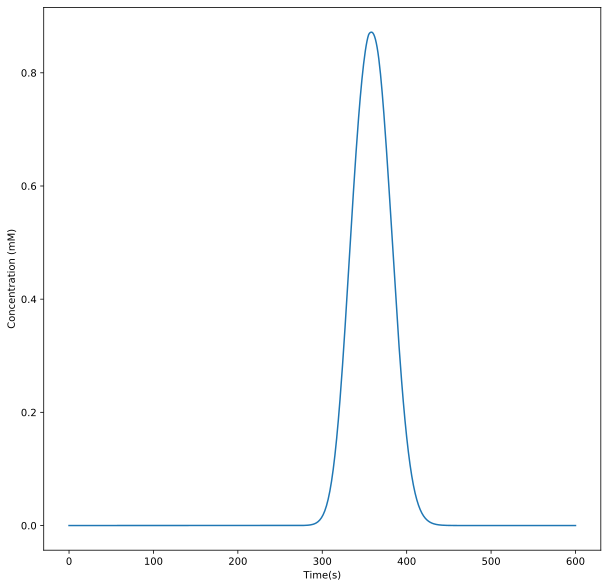

In [2]:
example_dir_0 = lesson_6 / "example_0"
example_dir_0.mkdir(exist_ok = True)

example0 = Cadet()

#give a filename for where the simulation should be saved
example0.filename = (lesson_5 / "example_0" / 'example.h5').as_posix()

example0.load()

example0.filename = (example_dir_0 / 'example.h5').as_posix()

#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example0.root.output.solution.solution_times,
                        example0.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create CADETMatch configuration

### Search Method
There are 5 main search methods and only 3 of them are normally used.
1. NSGA3

  This is the default evolutionary algorithm and the best choice to use when you don't know anything about your search space.


2. Multistart

  This is a multistart gradient descent algorithm. If your problem can be solved with gradient descent then this can be a very good choice. It creates an initial population the same way that NSGA3 does so that you don't have to worry about starting point. 


3. GraphSpace
  
  This is not for optimization and instead it is just for sampling the space. If you have a new problem and you have no idea what the range of any of the parameters are you can use this with a very large population and it will just evaluate the entire starting population and then terminate. This allows you to figure out what are plausiable ranges for your variables before using one of the search algorithms. When dealing with many variables it is still possible to miss regions of viable solutions inside large non-viable regions but in practice this has rarely been a problem.


4. MCMC
  
  This performans the error modeling and sampling. It is not an optimization algorithm and while it will probably find the optimum value while it runs it is very slow to do so and won't stop even if it finds the optimal value. This should also not be used directly. Normally NSGA3 is used and an option is set to continue with MCMC after NSGA3 has completed. This allows MCMC to be seeded with the best values from NSGA3 which dramatically improves convergence. If you have many variables and you run this directly it may never converge since it may never find high probability regions, much less sample from them effectively. 
 
 
5. Gradient
    
    This is a single start gradient descent algorithm. In order to work you need to give a good enough starting point. Generally it is advisable to use Multistart instead.

In [3]:
match = Dict()

#set the path to CADET simulator
match.CADETPath = cadet_path.as_posix()

#set the base directory (all paths are read relative to this directory)
match.baseDir = example_dir_0.as_posix()

#set where the results will be saved
match.resultsDir = 'fit_nsga3'

#this is used with gradient descent/refinement, Use 1 to have SSE for refinement and 0 to use the score for gradient refinement
#which setting you use depends on how well defined the optimum is
match.gradVector = 1

#set the search algorithm to use
match.searchMethod = 'NSGA3'

#set the population size per estimated variable (if you don't set this value 100 is used which is a good default)
match.population = 12

#this allows the system to run gradient descent on the final values to refine them further
match.finalGradRefinement = 1

#this is the number of generations without progress before the search is terminated (10 - 50 is a good range for this)
match.stallGenerations = 10

### Variable transforms
Variable transforms where covered in Lesson 5. This is here just for reference.

1. norm

  This is a simple transform that normalizes a variable from 0 to 1. This is best used when you have a variable that varies over less then 3 orders of magnitude.
  
  ```python
parameter = Dict()
parameter.transform = 'norm'
parameter.component = -1
parameter.bound = -1
parameter.location = "/input/model/unit_001/COL_POROSITY"
parameter.min = 0.2
parameter.max = 0.5
```
  
2. norm_log

  This transform takes the log before normalizing the variable from 0 to 1. Use this transform when your variable spans more than 3 orders of magnitude.
  
  ```python
parameter = Dict()
parameter.transform = 'norm_log'
parameter.component = -1
parameter.bound = -1
parameter.location = "/input/model/unit_001/COL_DISPERSION"
parameter.min = 1e-12
parameter.max = 1e-5
```
  
3. norm_keq

   This transform turns ka, kd in ka and keq=ka/kd and then takes a log transform and normalizes from 0 to 1.

  ```python
parameter = Dict()
parameter.transform = 'norm_keq'
parameter.component = 0
parameter.bound = 0
parameter.location = ["/input/model/unit_001/adsorption/LIN_KA",
                      "/input/model/unit_001/adsorption/LIN_KD"]
parameter.minKA = 1e-8
parameter.maxKA = 1e8
parameter.minKEQ = 1e-4
parameter.maxKEQ = 1e4
```


4. norm_volume_area

    This transform and the following one where created to solve the same common problem. When fitting bypass data and you model the tubing you are fitting the length, crosssectional area and dispersion of the tubing. Dispersion though is tied to the length such that a shorter length can just be compensated for with a higher diffusion. Basically we have fewer degrees of freedom that we are fitting with and since this is not a fluid dynamics model it is not physically accurate. This transformation couples the length and area together through the volume since volume is an identfiable quantity (since water is incompressible). We don't actually care much about the parameters for the tubing, it is just there to fill in for the real tubing so that fewer errors are carried into the column. Use this version if it is easier to measure the diameter of the tubing and use the other transform if measuring the length is easier. I just depends on your experimental setup.

  ```python
parameter = Dict()
parameter.transform = 'norm_volume_area'
parameter.area_location = "/input/model/unit_003/COL_DISPERSION"
parameter.length_location = "/input/model/unit_004/COL_DISPERSION"
parameter.component = -1
parameter.bound = -1
parameter.minVolume = 1e-6
parameter.maxVolume = 1e-5
parameter.minArea = 1e-4
parameter.maxArea = 1e-3
```
    

5. norm_volume_length

    Use this transform if measuring the length accurately is easier than measuring the diameter of the tubing. If you are lumping together all the tubing in front of the column or after the column together and you have multiple diameters it doesn't matter which of these transforms you choose.

  ```python
parameter = Dict()
parameter.transform = 'norm_volume_area'
parameter.area_location = "/input/model/unit_003/COL_DISPERSION"
parameter.length_location = "/input/model/unit_004/COL_DISPERSION"
parameter.component = -1
parameter.bound = -1
parameter.minVolume = 1e-6
parameter.maxVolume = 1e-5
parameter.minLength = 0.25
parameter.maxLength = 0.75
```


6. set_value

    This is a different kind of transform. What it allows you to do is copy a value from place to another. This is important if you are estimating axial dispersion for identical tubing in front of and behind the column. You want the same axial dispersion for both pieces of tubing but you only want to estimate one variable. With this you can estimate axial dispersion for the first piece of tubing and then copy the value over to the other piece of tubing. This is also required if you want to estimate SMA_LAMDA. Whenever SMA_LAMBDA change the initial bound salt concentration also much change or electronuetrality would be violated.
    
```python
parameter = Dict()
parameter.transform = 'set_value'
parameter.componentFrom = -1
parameter.boundFrom = -1
parameter.locationFrom = "/input/model/unit_001/COL_DISPERSION"
parameter.componentTo = -1
parameter.boundTo = -1
parameter.locationTo = "/input/model/unit_001/COL_DISPERSION"
```  

In [4]:
parameter1 = Dict()
parameter1.transform = 'norm_log'

# -1 means the parameter is independent of components
parameter1.component = -1

# -1 means the paramter is indepdent of bound states
parameter1.bound = -1

parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-6

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.2
parameter2.max = 0.5

match.parameters = [parameter1, parameter2]

### Scores

Scores are how the search algorithm measures if a solution is better or worse than what it had before. Without a good score system an optimizer can't work. There are many scores available and I am going to cover the most commonly used ones and when you should use them. You can see all of them at https://github.com/modsim/CADET-Match/tree/master/CADETMatch/scores . Most of these scores are based on physical understanding of the problem and it is pretty easy to add new scores. If there is a feature you can identify in your problem that ties to one of the variables being estimated then go ahead and make a score for it. Maybe for your isotherm the width of the peak or some other feature reveals important information.

1. **Shape**

  This is the default score used when fitting an isotherm. It looks at the shape, position, and height of the peak. It has a small initial penalty for the peak being out of position in time and increases as the peak gets further away. This is to deal with the problem of pump delays and other experimental errors. The best fit may not be and often is not the peak that is in exactly the right location but it is the one with the right shape. The shape is determined by the physics which is why it is so heavily emphasied in the score system.

2. **ShapeDecay**

  This is the default score to use when fitting transport parameters. Transport experiments are more difficult because you MUST make sure that as few errors as possible happened in the physical experiment. On most AKTA type systems if there is an alarm the timer for data collection is also paused until the alarm is cleared and the system resumes. This results in data that has no gap in the time. However, the chemicals are still reacting and moving even if the pumps are off and data collection stops. Any such error that occurs will result in the diffusion being wrong and the longer the error persists before being fixed the more wrong the estimate for diffusion will be. Things like pump delays or other pauses in the system can cause problems with estimating volume or porosity. Any errors that occur in transport experiments will be carried through to isotherm parameters which harms scaleup later.

3. **DextranShape**

  Dextran is a nice tracer overall but it has non ideal behavior in most systems. You normally see this in strange tailing behavior. What this means is that only the front side of the peak can be used. This score specifically looks only at the front side of the peak.
  
4. **DextranSSE**

  This works like DextranShape and cuts out just the front part of the peak but uses SSE for the score. **This score can not be combined with any of the other scores since it does not range from 0 to 1.**

4. **fractionationSlide**

  If you have a fractionation proble use this score. Internally it is a little complex. After each simulation for each species it numerically slides the chromatogram back and forward in time and refactionates at each time to find which location best matches the experimental data to find the time difference between the synthetic and experimental peak along with a shape comparison at that time.

5. **SSE**

  This is the Sum of Squared Errors. **This score can not be combined with any of the other scores since it does not range from 0 to 1.**

6. **AbsoluteHeight** and **AbsoluteTime**

  These scores are needed by the MCMC system. They are absolute measurements of height and time since the beginning of the simulation. They are used to capture the impact of errors that have an assymetric impact on the peaks.

In [5]:
#setup an experiment
experiment1 = Dict()

#where is the data to match against?
experiment1.csv = "example.csv"

#where is the data in cadet that needs to match the experimental data?
experiment1.isotherm = "/output/solution/unit_001/SOLUTION_OUTLET_COMP_000"

#where is the HDF5 file that has the base simulation in it (this simulation must be runnable even if the parameters are widly off)
experiment1.HDF5 = "example.h5"

#what is the name of this experiment?
experiment1.name = "main"


#set score(s) to use for each experiment
feature1 = Dict()

#set the name to use for this score, you can't use the same name for two scores in the same experiment
feature1.name = "Pulse"

#set which score to use (if you use SSE don't combine any other scores)
feature1.type = 'DextranShape'

#this sets what scores will be used for this experiment
experiment1.features = [feature1,]

#this sets what experiments will be used in the match
match.experiments = [experiment1,]

match_file = example_dir_0 / 'example_nsga3.json'

with (match_file).open('w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

## Create match using jupyter interface
This creates a simple Match object to use for parameter estimation. This is useful when running a match from inside Jupyter notebook. Most of the time this is only done for small matches or when you are running a jupyter notebook on a more powerful server. All of the same results are generated as when the matching software is run directly on the command line and the full results can still be viewed. The jupyter notebook interface just shows a few highlights.

In [6]:
sim = Match((example_dir_0 / 'example_nsga3.json').as_posix())

## Start parameter estimation
Once the Match object has been created all that you need to use is call .start_sim() and the output will be written to the notebook as the matching process runs.

The first few lines tell you what version of python is being used and how many workers are being used. After that the system provides some output at the end of each generation. 

> [2019-09-27 12:29:34,593] util      (b'127.0.0.1:61306') INFO    Generation: 0 	Population: 24 	Average Score: 0.968 	Best: 0.981 	Minimum Score: 0.942 	Best: 0.973 	Product Score: 0.967 	Best: 0.981

The above line gives information for when the line was created, what generation the system is on, how long the population is and score information. For most scores the best value is 1.0. The Average, Minimum and Products scores are the values based on the entire population while the Best versions are the scores for only the items on the pareto front. When first starting out the normal scores are usually much lower then the best scores and as the system converges they also tend to get closer.

In [7]:
resultDir = Path(match.baseDir) / match.resultsDir
print("Your results are located at", resultDir.as_posix(), '\n\n')

#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
deleteResultDir(resultDir, match, match_file)

sim.start_sim()

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/fit_nsga3 


[2019-10-16 13:21:47,654] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 13:21:47,654] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 13:21:47,654] launcher  INFO    Worker distribution: 

[2019-10-16 13:21:47,654] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 13:21:50,221] util      (b'127.0.0.1:65050') INFO    example.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-16 13:21:50,360] match     (b'127.0.0.1:65050') INFO    simulation took 0.13899588584899902

[2019-10-16 13:21:50,602] gradFD    (b'127.0.0.1:65050') INFO    grad simulation took 0.21275067329406738

[2019-10-16 13:21:50,602] gradFD    (b'127.0.0.1:65050') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/fit_nsga3/misc/template_main_grad.h5 abstol=4.71e-09  reltol=

[2019-10-16 13:22:19,102] util      (b'127.0.0.1:65050') INFO    Generation: 38 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-16 13:22:19,766] util      (b'127.0.0.1:65050') INFO    Generation: 39 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-16 13:22:20,414] util      (b'127.0.0.1:65050') INFO    Generation: 40 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-16 13:22:21,113] util      (b'127.0.0.1:65050') INFO    Generation: 41 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-16 13:22:21,777] util      (b'127.0.0.1:65050') INFO    Generation: 42 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-16 13:22:22,570] util      (b'127.0.0.1:65050') INFO    Generation: 43 	Population: 24 	Average Score

## Parameter estimation from the command line
Most of the time paramter estimation is run from the command line. This makes it easy to run it on a remote computer and restart if something goes wrong. You can also run this under the control of a batch system and is how the software is typically used. Complex parameter estimation with multiple experiments and many variables can take a week or more to run to completion. The matching software peridically writes out graphs and other information as it runs. If you notice that the answer is good enough you can end matching early. I have seen systems get 99% of the final answer within a day and spend another week refining it with minor improvements. There is no absolute rule for this.

For almost all cases what you want to run is

> python -m CADETMatch --match -j /path/to/file.json

It is possible that you will need to change python to python3 depending on your system

If you want to force the system to generate graphs for all the simulations it has so far immediately you can run

> python -m CADETMatch --generate_graphs -j /path/to/file.json

If you have not passed the first generation some graphs won't be generated since the data won't be available yet.

If you run this version from inside a jupyter notebook by use ! to run an external program the output won't show up until the whole estimation finishes. If you are going to run this from inside a jupyter notebok use the jupyter interface covered above. This is here as an example to show how to run the software from the command line.

In [8]:
#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
deleteResultDir(resultDir, match, match_file)

json_path = (example_dir_0 / 'example_nsga3.json').as_posix()

command = 'python -m CADETMatch --match -j "%s"' % json_path

print(command)

!{command}

python -m CADETMatch --match -j "C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/example_nsga3.json"
[2019-10-16 13:23:16,868] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013
[2019-10-16 13:23:16,868] launcher  INFO    Deploying 12 worker(s) over 1 host(s).
[2019-10-16 13:23:16,869] launcher  INFO    Worker distribution: 
[2019-10-16 13:23:16,869] launcher  INFO       127.0.0.1:	11 + origin
[2019-10-16 13:23:19,415] util      (b'127.0.0.1:61213') INFO    example.h5 abstol=4.71e-05  reltol=0.0001
[2019-10-16 13:23:19,557] match     (b'127.0.0.1:61213') INFO    simulation took 0.14199328422546387
[2019-10-16 13:23:19,810] gradFD    (b'127.0.0.1:61213') INFO    grad simulation took 0.22299981117248535
[2019-10-16 13:23:19,810] gradFD    (b'127.0.0.1:61213') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/fit_nsga3/misc/template_main_grad.h5 abstol=4.71e-09  re

## Complete results
Sorry this next line only works on Windows. On your own system you can use whatever program you use for managing files to open up the result dir and see the same thing.

The system creates a number of sub directories and depending on what settings are in the JSON file some will be empty.

The import ones are

1. log
  This contains all the log files from the system. If something goes wrong the information is usually here to find the problem and fix it. This is especialy useful for us to help with a problem.
2. meta
  This contains all the results on the pareto front of meta scores. Your best results will be in this folder. There are simulations, images and results in csv and xlsx format to view.
3. progress
  This folder watches the general progress of the algorithm. In this folder you can see if your variables are identifiable or the progress the search method is making.
4. space
  This folder has plots for what the search space looks like. This is especially useful for debugging. Based on graphs in this folder you can expand or contract the search range for your variables which can improve the fits.
  
There are also some important items in this folder
1. error.csv
  If any simulation fails it will be recorded here
2. json file
  This is the JSON used to create this simulation. It is a copy of the JSON file you started the matching process with
3. progress.csv
  This file contains some information on algorithm progress. Of special interest are the last two columns that show the last generation where a new item was added to the pareto front of meta scores and how many generations in a row that progress has been made. If enough generations pass without progress the search will terminate.
4. result.h5 
  This is an HDF5 file that contains enormous information about the system. It has the entire population, the scores for all items, and other information. With HDFview you can easily view these files and with python you can read any information you want from these files.
5. csv file
  There is one last csv file that is named based on the JSON configuration file and it shows every simulation the system has run along with the scores for that simulation.

In [21]:
!explorer {resultDir}

## Create corner plots
These are frequency plots of each variable in your system along with their correlations. What you are looking for is a single peak and this indicates that your variable is identifiable. The peak may be more or less narrow depending on the ranges you gave to the optimizer. If you use an early stopping criteria these plots probably won't be accurate. What is happening is that as the system converges it searches around the best found values to try and find better ones. This means that there are many similar values and so the frequency goes up which shows up as a peak.

Corner plot in search space


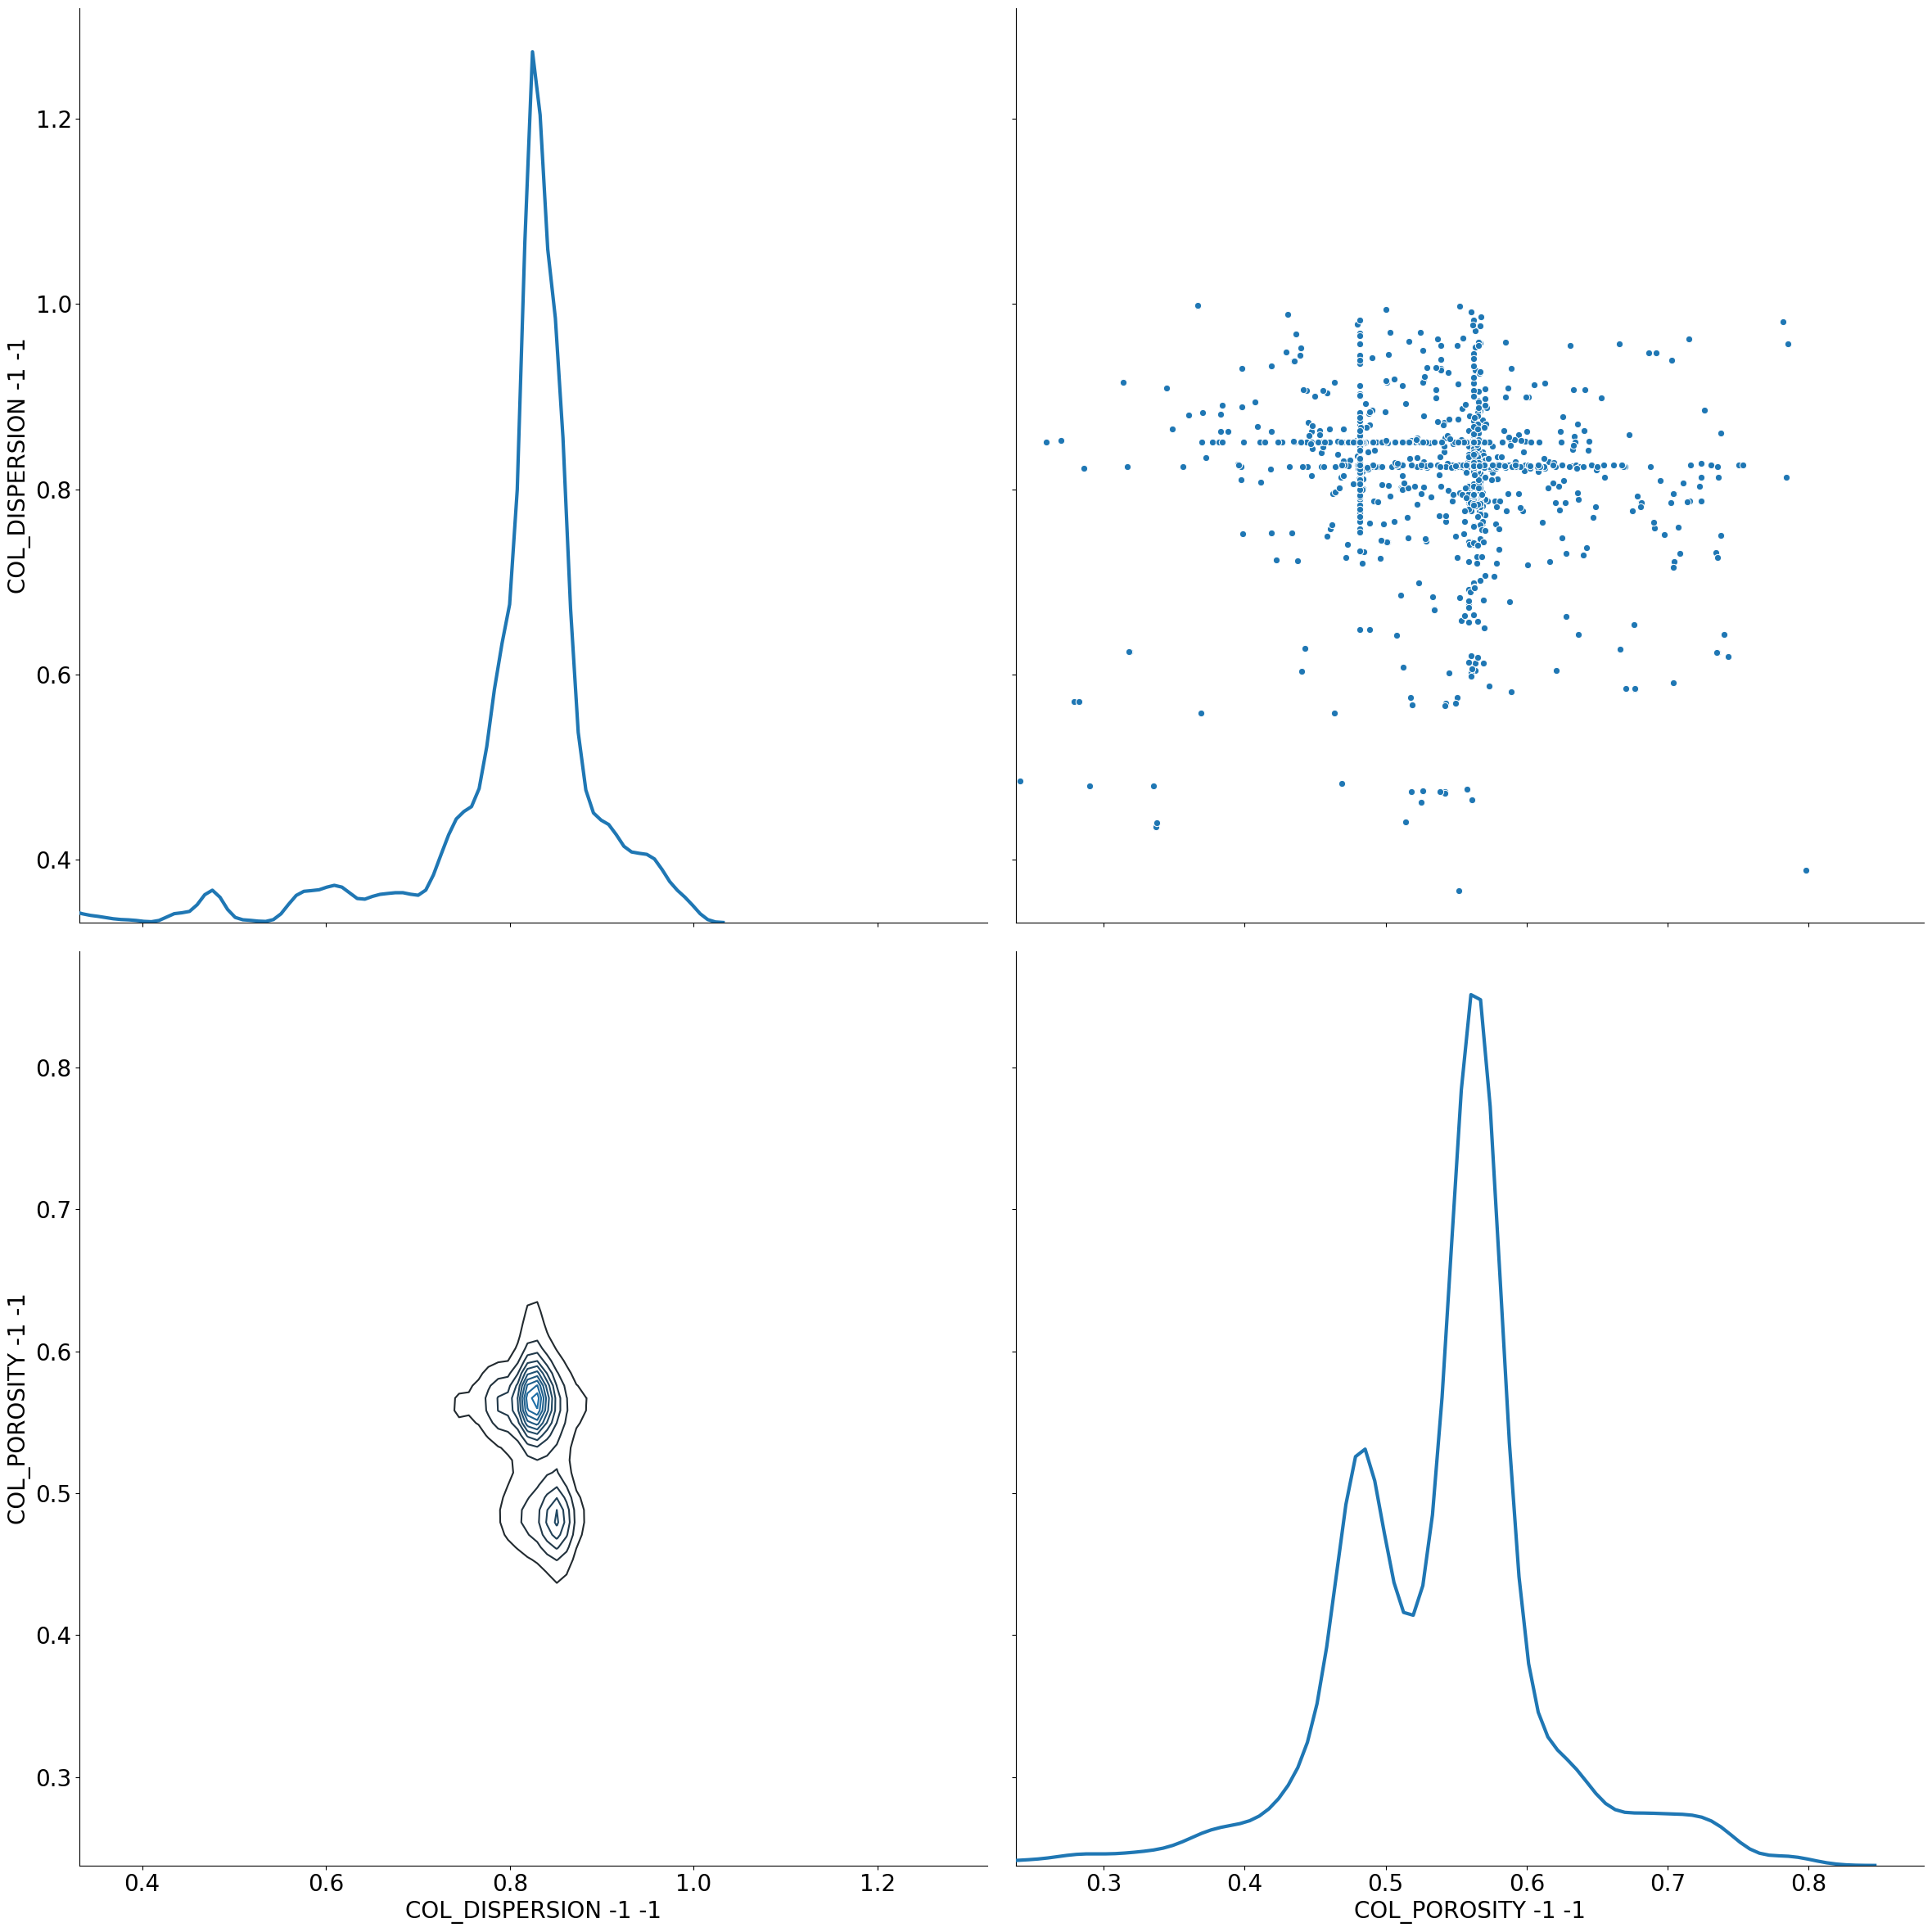

Corner plot in original space


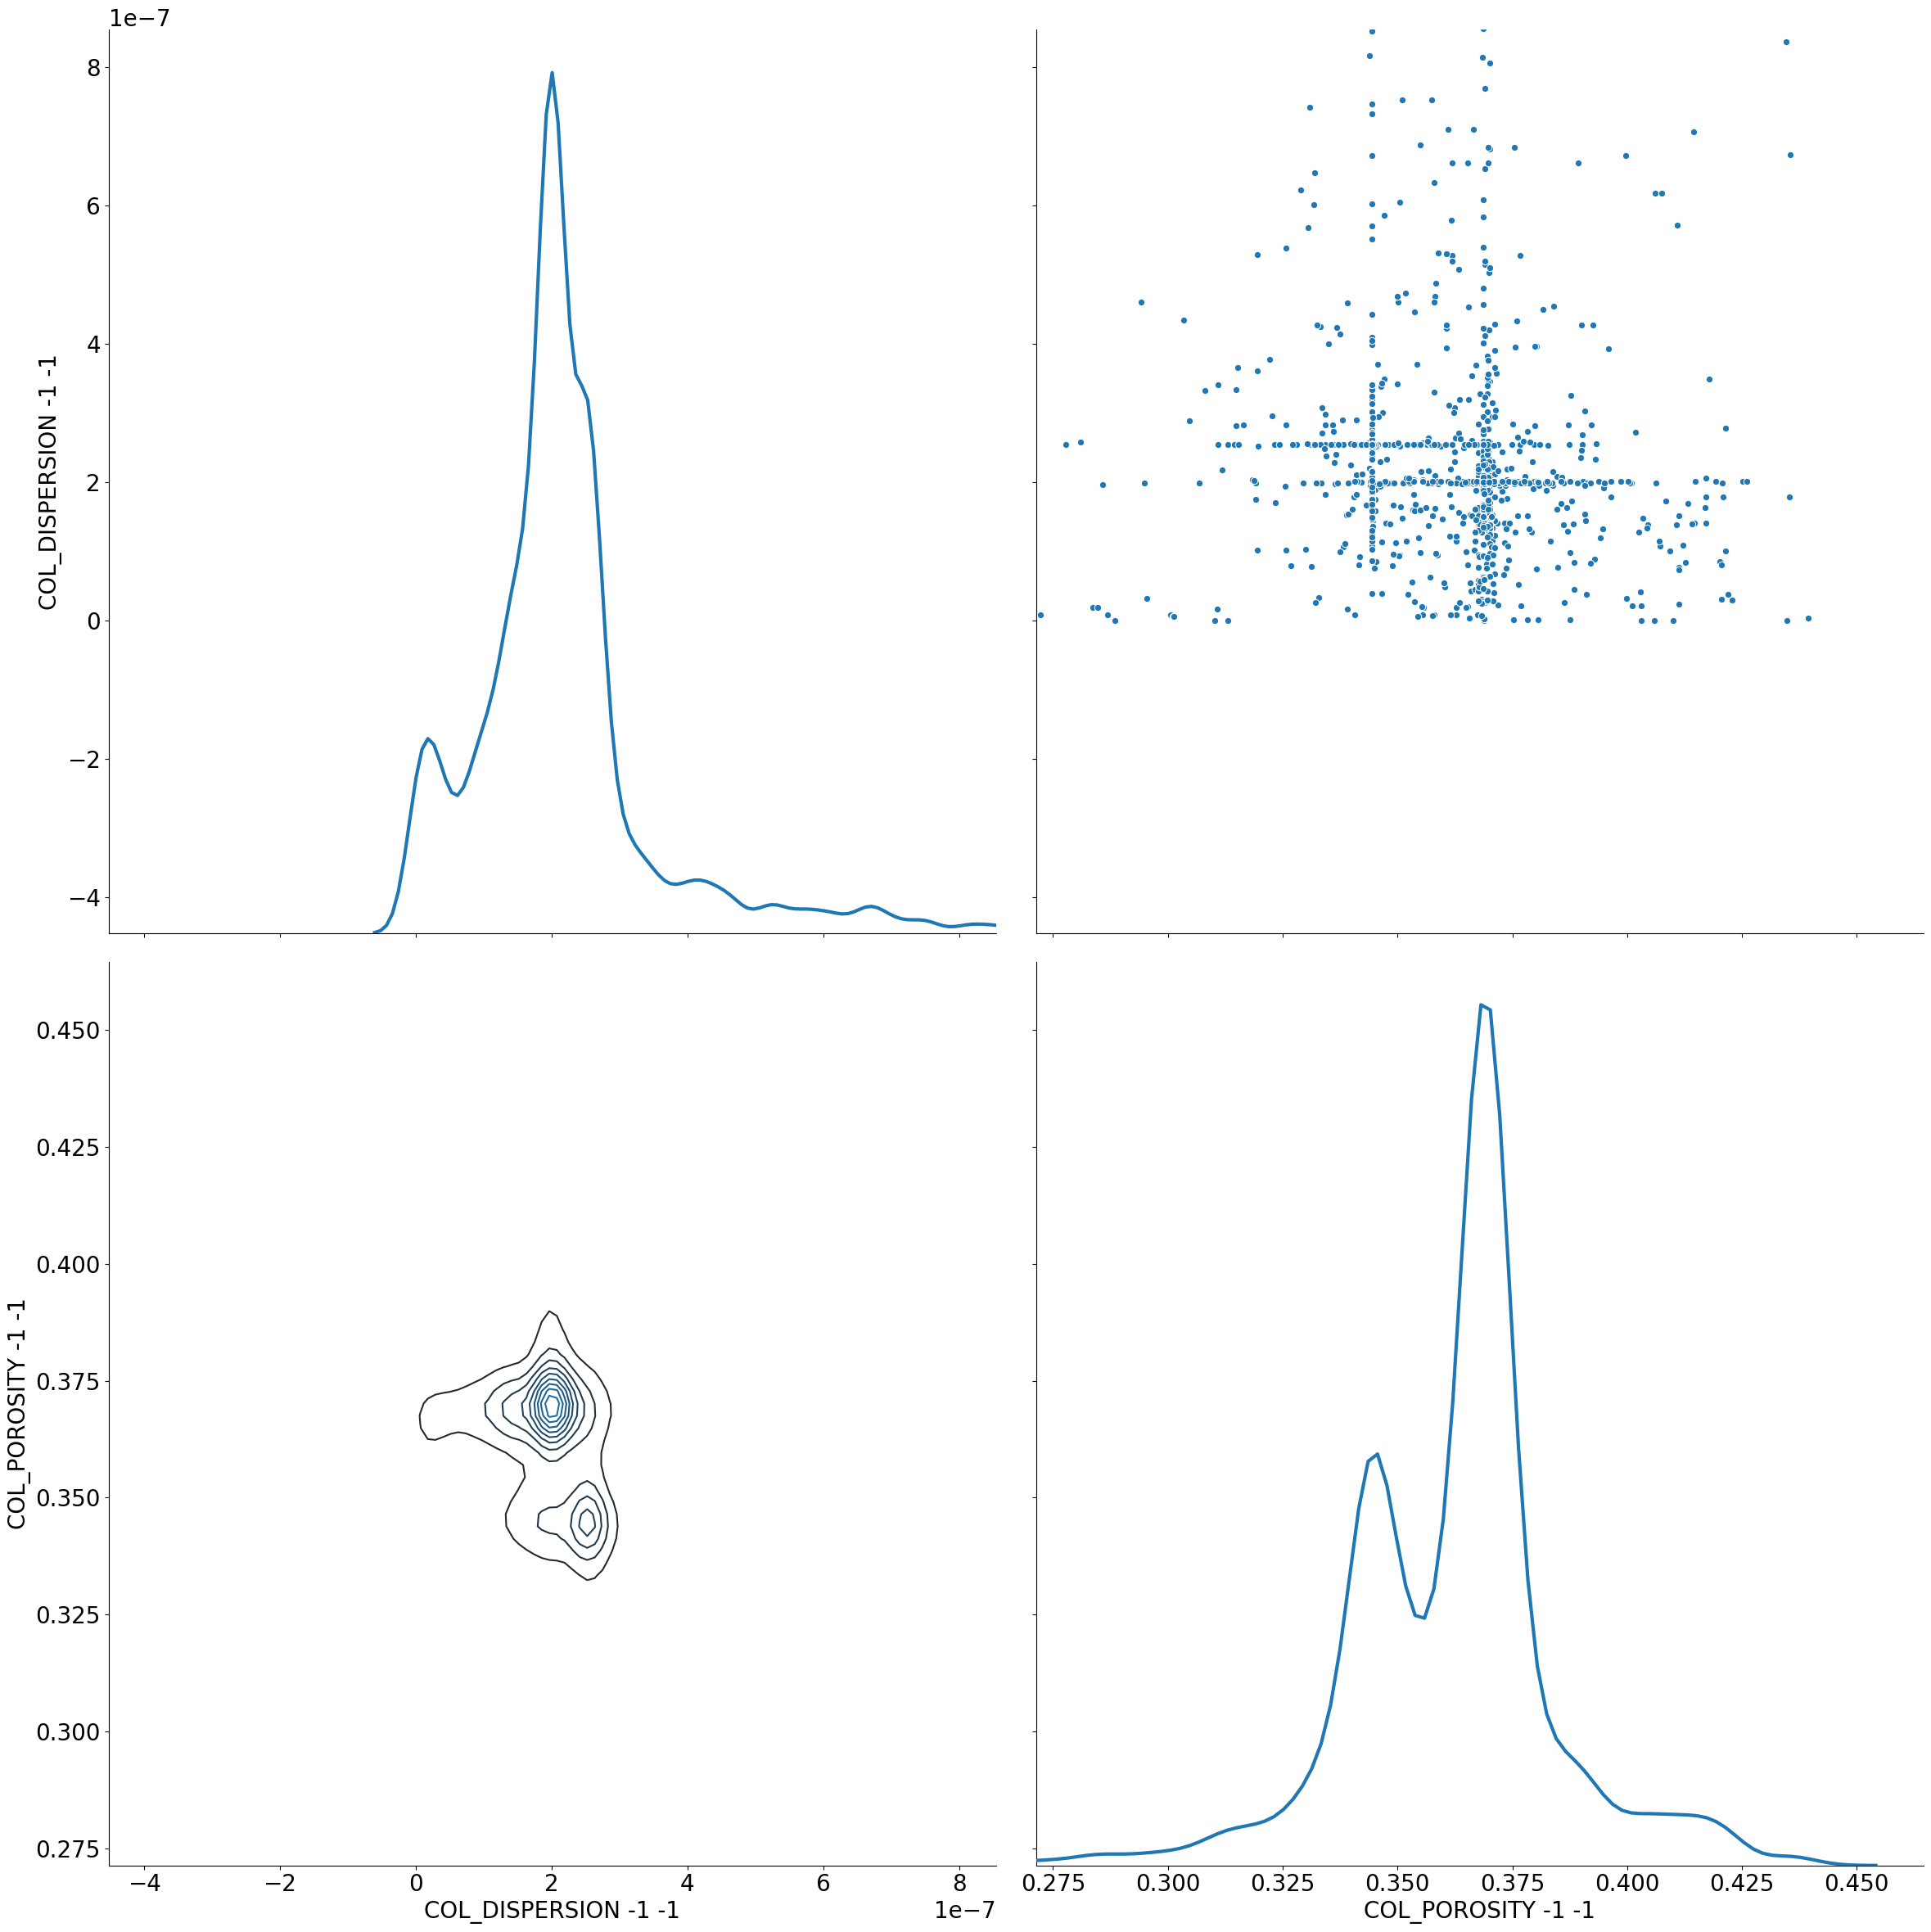

In [9]:
sim.plot_corner()

## Best plots
This draws a selection of items from the meta folder. It will look in the folder and find the highest Product Root Score, Min Score and Mean Score and the lowest SSE and plot all of those entries. There may still be other items in those folders which are compromises between these scores. The plot will show the ID of the best found item, by what measurements it is the best and what its paramters are.

Best item 3234eaca4305444b5d4f0ab6b685a0a9 for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 16 13:23:59 2019,3234eaca4305444b5d4f0ab6b685a0a9,GRAD,NaN,1.999928e-07,0.369999,1.0,0.999999,1.0,0.999999,1.0,4.469398e-07


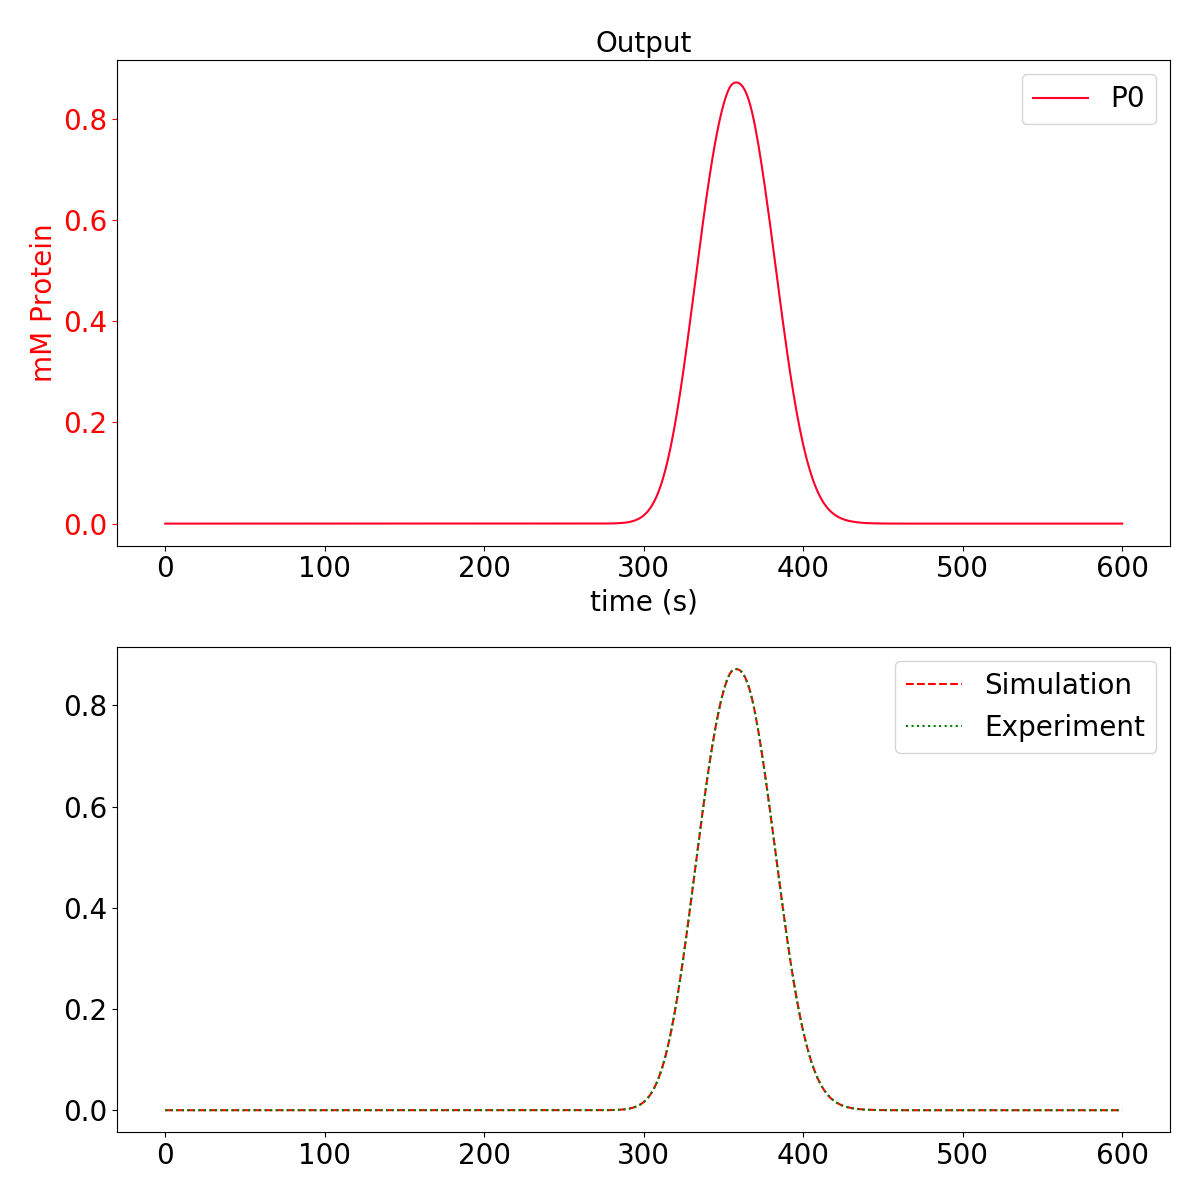

In [10]:
sim.plot_best()

## Comparing to the correct answer
After all of the fitting is done the results can be compared to the correct answer when doing synthetic experiments. In this case we can see the error is well under 0.1% for all variables which is very good. That would indicate that if we ran this experiment accurately in real life it could work. If a synthetic experiment can not recover the original value then the real experiment will not find those variables accurately either. 

In [11]:
best ,score, best_score = sim.get_best()
true_values = numpy.array([example0.root.input.model.unit_001.col_dispersion, 
                           example0.root.input.model.unit_001.col_porosity])
for key,value in best_score.items():
    print("Method: %s" % key)
    for name, val, true_value in zip(sim.cache.parameter_headers, value, true_values):
        print("%s = %.2e   error: %.2g%%" % (name, val, numpy.abs(val-true_value)/val*100))
    print('\n')

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0036%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.00016%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0036%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.00016%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0036%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.00016%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07   error: 0.0036%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.00016%




## Change the search method
We can also take the exact same setup we just made and change the search method from NSGA3 to Multistart and store the results in a new folder. You can see how the different methods compare.

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/fit_grad 


[2019-10-16 13:35:20,929] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 13:35:20,929] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 13:35:20,929] launcher  INFO    Worker distribution: 

[2019-10-16 13:35:20,929] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 13:35:23,486] util      (b'127.0.0.1:61486') INFO    example.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-16 13:35:23,613] match     (b'127.0.0.1:61486') INFO    simulation took 0.12700104713439941

[2019-10-16 13:35:23,865] gradFD    (b'127.0.0.1:61486') INFO    grad simulation took 0.22103166580200195

[2019-10-16 13:35:23,865] gradFD    (b'127.0.0.1:61486') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/fit_grad/misc/template_main_grad.h5 abstol=4.71e-09  reltol=1e

[2019-10-16 13:37:00,200] launcher  (127.0.0.1:53970) INFO    Root process is done.

[2019-10-16 13:37:00,201] launcher  (127.0.0.1:53970) INFO    Finished cleaning spawned subprocesses.

Best item 76d4749873803bb22619636ca951ca8e for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 16 13:36:41 2019,76d4749873803bb22619636ca951ca8e,GRAD,NaN,1.878226e-07,0.368919,0.999996,0.999999,0.999998,0.999996,0.999998,0.004425


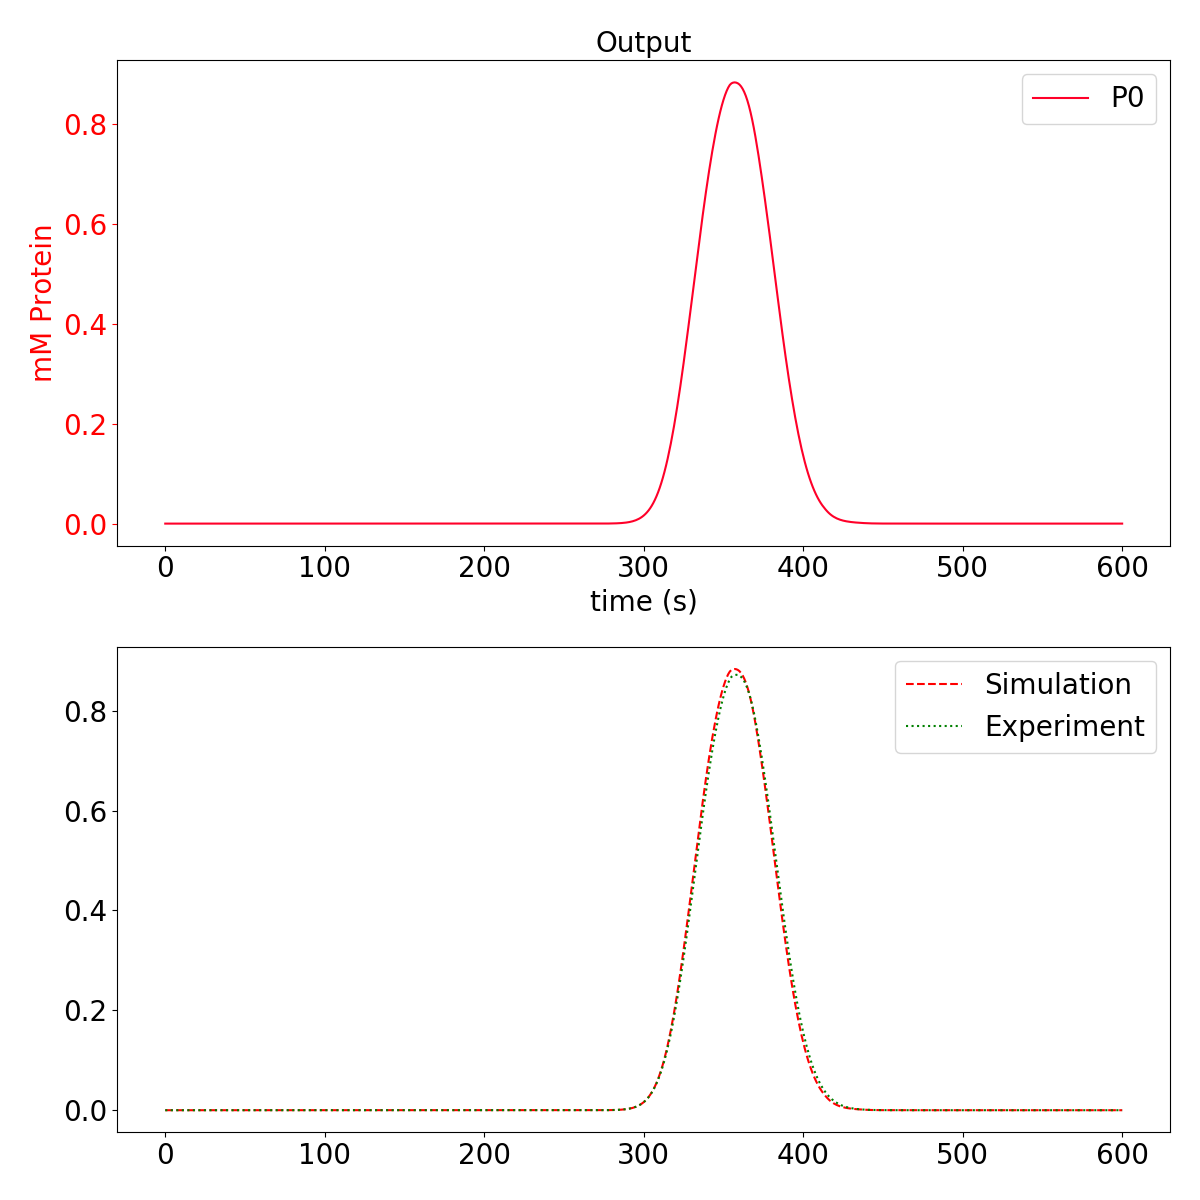

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.88e-07  true_value = 2.00e-07 error: 6.5%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.29%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.88e-07  true_value = 2.00e-07 error: 6.5%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.29%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.88e-07  true_value = 2.00e-07 error: 6.5%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.29%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.88e-07  true_value = 2.00e-07 error: 6.5%
COL_POROSITY Comp:-1 Bound:-1 = 3.69e-01  true_value = 3.70e-01 error: 0.29%




In [12]:
match_grad = match.copy()

match_grad.gradVector = 0
match_grad.resultsDir = 'fit_grad'
match_grad.searchMethod = 'Multistart'


match_file = example_dir_0 / 'example_gradient.json'

with (match_file).open('w') as json_file:
    json.dump(match_grad.to_dict(), json_file, indent='\t')
    
true_values = numpy.array([example0.root.input.model.unit_001.col_dispersion, 
                           example0.root.input.model.unit_001.col_porosity])
    
sim_grad = run_match(match_grad,
                    match_file,
                    true_values,
                    delete=True)

## Change the population size
Sometimes the population size is not large enough and needs to be increased to find better answers.

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/fit_nsga3_large 


[2019-10-15 16:01:01,359] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-15 16:01:01,359] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-15 16:01:01,359] launcher  INFO    Worker distribution: 

[2019-10-15 16:01:01,360] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-15 16:01:04,266] util      (b'127.0.0.1:63436') INFO    example.h5 abstol=4.71e-05  reltol=0.0001

[2019-10-15 16:01:04,389] match     (b'127.0.0.1:63436') INFO    simulation took 0.12302684783935547

[2019-10-15 16:01:04,634] gradFD    (b'127.0.0.1:63436') INFO    grad simulation took 0.2150285243988037

[2019-10-15 16:01:04,634] gradFD    (b'127.0.0.1:63436') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_6/example_0/fit_nsga3_large/misc/template_main_grad.h5 abstol=4.71e-

[2019-10-15 16:02:18,083] launcher  (127.0.0.1:60858) INFO    Root process is done.

[2019-10-15 16:02:18,084] launcher  (127.0.0.1:60858) INFO    Finished cleaning spawned subprocesses.

Best item 7c1e36365a04fff4f489fadde821dd8e for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Tue Oct 15 16:01:31 2019,7c1e36365a04fff4f489fadde821dd8e,EVO,NaN,1.979818e-07,0.369794,1.0,1.0,1.0,1.0,1.0,0.000174


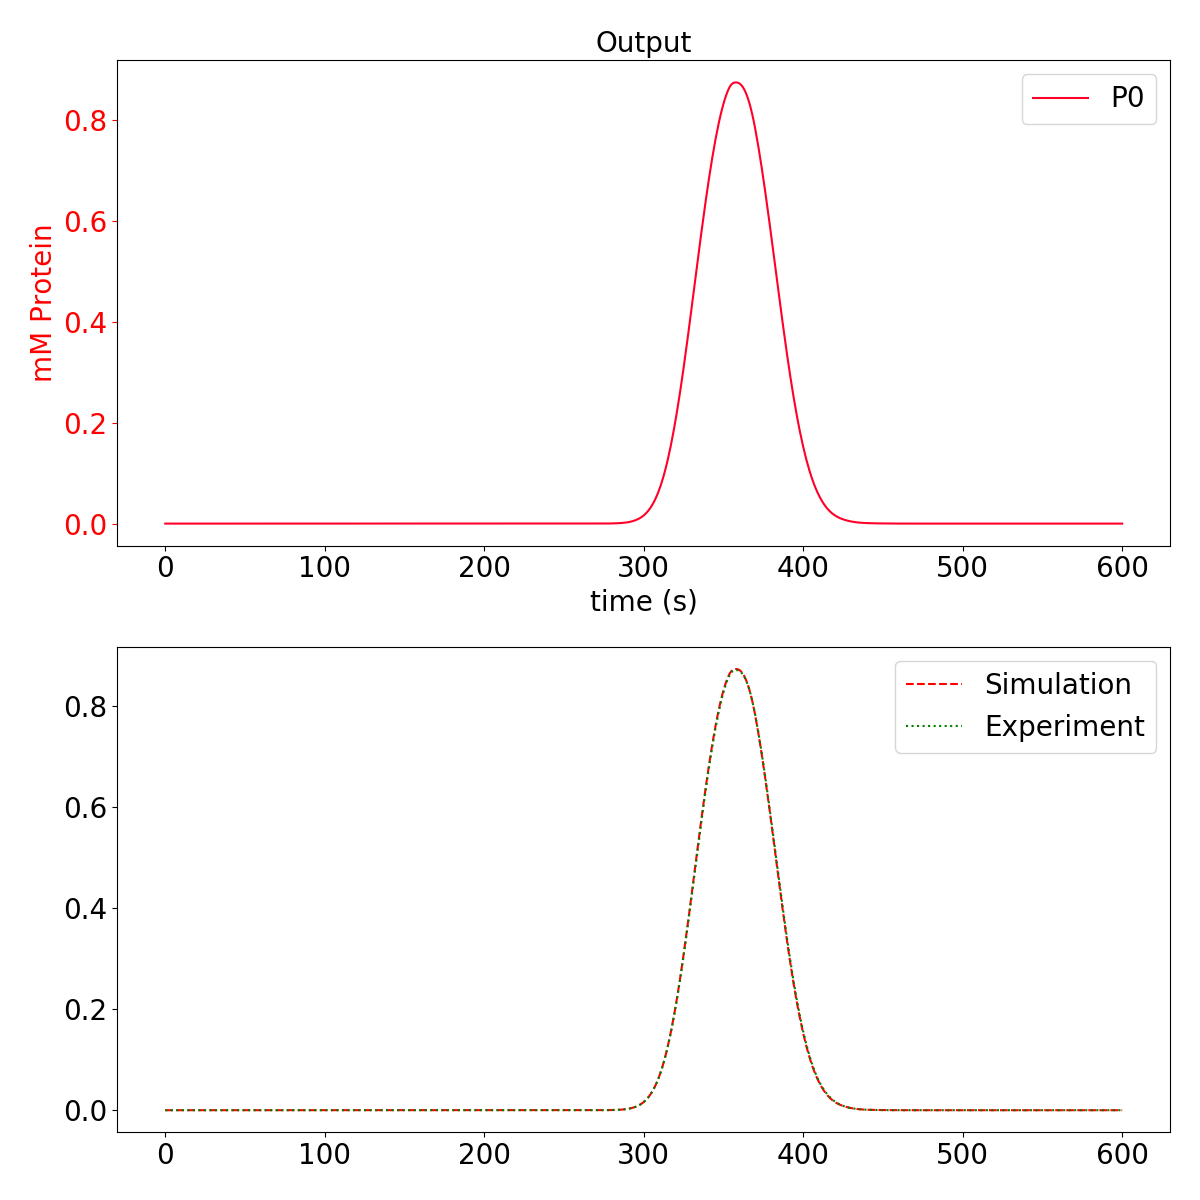

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.98e-07  true_value = 2.00e-07 error: 1%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.056%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.98e-07  true_value = 2.00e-07 error: 1%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.056%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.98e-07  true_value = 2.00e-07 error: 1%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.056%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 1.98e-07  true_value = 2.00e-07 error: 1%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.056%




In [28]:
match_grad_large = match.copy()

match_grad_large.gradVector = 0
match_grad_large.resultsDir = 'fit_nsga3_large'
match_grad_large.searchMethod = 'NSGA3'
match_grad_large.population = 24


match_file_large = example_dir_0 / 'example_nsga3_large.json'

with (match_file_large).open('w') as json_file:
    json.dump(match_grad_large.to_dict(), json_file, indent='\t')
   
true_values = numpy.array([example0.root.input.model.unit_001.col_dispersion, 
                           example0.root.input.model.unit_001.col_porosity])
    
sim_grad_large = run_match(match_grad_large,
                    match_file_large,
                    true_values,
                    delete=True)

## Changing the score
You can also change to an SSE based score and use gradient descent. For this problem it should provide very good results.

Your results are located at F:/temp/cadet_tutorial/lesson_4/fit_sse 


[2019-10-02 11:11:41,935] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-02 11:11:41,935] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-02 11:11:41,935] launcher  INFO    Worker distribution: 

[2019-10-02 11:11:41,935] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-02 11:11:45,628] multistart (b'127.0.0.1:54649') INFO    Population [Individual('d', [0.40564270052662443, 0.83382014582473]), Individual('d', [0.3530413188645931, 0.48344316615120086]), Individual('d', [0.402360620977364, 0.4295398669145485]), Individual('d', [0.43667485642488646, 0.0013722638923920893]), Individual('d', [0.6157030475698335, 0.836731753780075]), Individual('d', [0.1116611003683522, 0.17873868758649658]), Individual('d', [0.7618247072190997, 0.6499250592696417]), Individual('d', [0.5116120

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_SSE,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 2 11:12:07 2019,ac09767019da367807da9cac553e5adf,GRAD,NaN,1.999996e-07,0.37,-7.174236e-16,-7.174236e-16,-7.174236e-16,-7.174236e-16,7.174236e-16


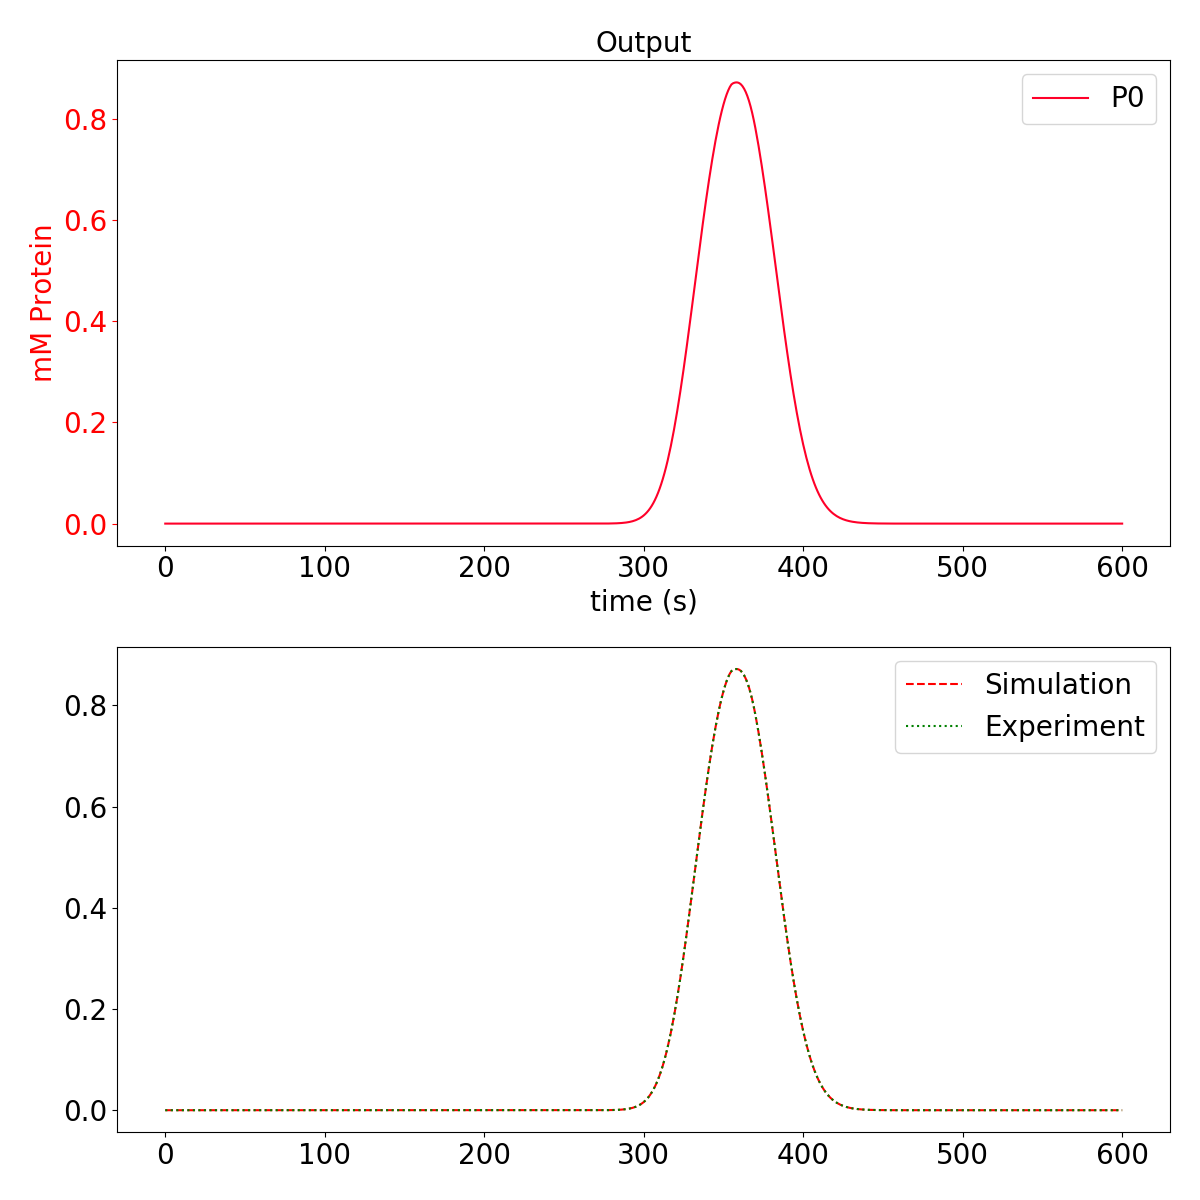

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00021%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 9.3e-06%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00021%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 9.3e-06%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00021%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 9.3e-06%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00021%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 9.3e-06%




In [18]:
match_sse = match.copy()

match_sse.resultsDir = 'fit_sse'
match_sse.searchMethod = 'Multistart'
match_sse.experiments[0].features[0].type = 'DextranSSE'


match_file = lesson_4 / 'example_sse.json'

with (match_file).open('w') as json_file:
    json.dump(match_sse.to_dict(), json_file, indent='\t')
    
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])

sim_sse = run_match(match_sse,
                    match_file,
                    true_values,
                    delete=True)

## A large population can still help
Partial Differential Equations are complex and a different start location can provide a better result. The best way to deal with this is to increase the population size.

Your results are located at F:/temp/cadet_tutorial/lesson_4/fit_sse_large 


[2019-10-02 11:12:29,739] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-02 11:12:29,739] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-02 11:12:29,739] launcher  INFO    Worker distribution: 

[2019-10-02 11:12:29,739] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-02 11:12:33,445] multistart (b'127.0.0.1:62339') INFO    Population [Individual('d', [0.30886328060425494, 0.8555729059176355]), Individual('d', [0.21481148469983813, 0.3217151796368166]), Individual('d', [0.0324107905765888, 0.17163505944076896]), Individual('d', [0.05998123679460732, 0.012685272320708818]), Individual('d', [0.07689120285179096, 0.359806164082227]), Individual('d', [0.5590341828291389, 0.17732005216344815]), Individual('d', [0.43358540606104135, 0.7530113973079148]), Individual('d',

[2019-10-02 11:12:35,136] gradFD    (b'127.0.0.1:62339') INFO    removed [0.5282021920754107, 0.0782795740513833] for insufficient overlap in gradient descent

[2019-10-02 11:12:35,136] gradFD    (b'127.0.0.1:62339') INFO    removed [0.16789683818914625, 0.6458283496853358] for insufficient overlap in gradient descent

[2019-10-02 11:12:35,136] gradFD    (b'127.0.0.1:62339') INFO    removed [0.6519466460347927, 0.7234895141059292] for insufficient overlap in gradient descent

[2019-10-02 11:12:35,136] gradFD    (b'127.0.0.1:62339') INFO    removed [0.5384954236914801, 0.6208286838116831] for insufficient overlap in gradient descent

[2019-10-02 11:12:35,136] gradFD    (b'127.0.0.1:62339') INFO    removed [0.3622713091794124, 0.9257462817500773] for insufficient overlap in gradient descent

[2019-10-02 11:12:35,136] gradFD    (b'127.0.0.1:62339') INFO    removed [0.4420463487685985, 0.8355013337108371] for insufficient overlap in gradient descent

[2019-10-02 11:12:35,137] gradFD    (b'

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_SSE,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 2 11:13:05 2019,25db7930d932a51f93589b161570066d,GRAD,NaN,1.999994e-07,0.37,-1.335376e-15,-1.335376e-15,-1.335376e-15,-1.335376e-15,1.335376e-15


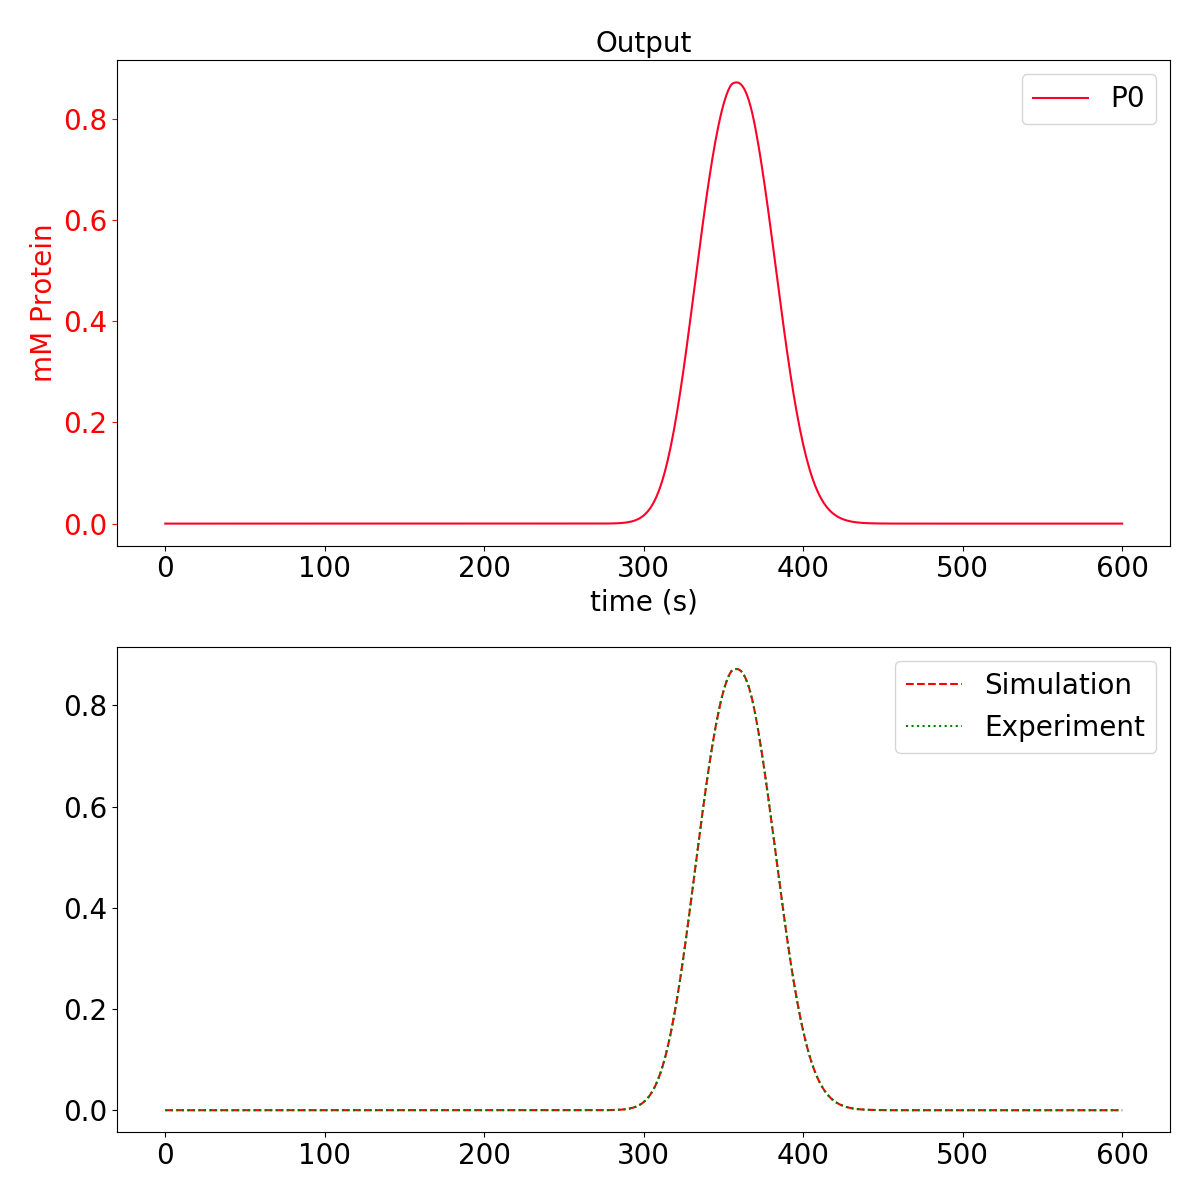

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00028%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.3e-05%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00028%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.3e-05%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00028%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.3e-05%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00028%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.3e-05%




In [19]:
match_sse_large = match.copy()

match_sse_large.resultsDir = 'fit_sse_large'
match_sse_large.searchMethod = 'Multistart'
match_sse_large.population = 24
match_sse_large.minPopulation = 24
match_sse_large.maxPopulation = 24
match_sse_large.experiments[0].features[0].type = 'DextranSSE'


match_file = lesson_4 / 'example_sse_large.json'

with (match_file).open('w') as json_file:
    json.dump(match_sse_large.to_dict(), json_file, indent='\t')

true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
    
sim_sse_large = run_match(match_sse_large,
                    match_file,
                    true_values,
                    delete=True)

## Look back at the langmuir example

Lets quickly look back at the Langmuir example in Lesson 5 and this time solve it with NSGA3 and automatic starting points.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_6/example_1/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


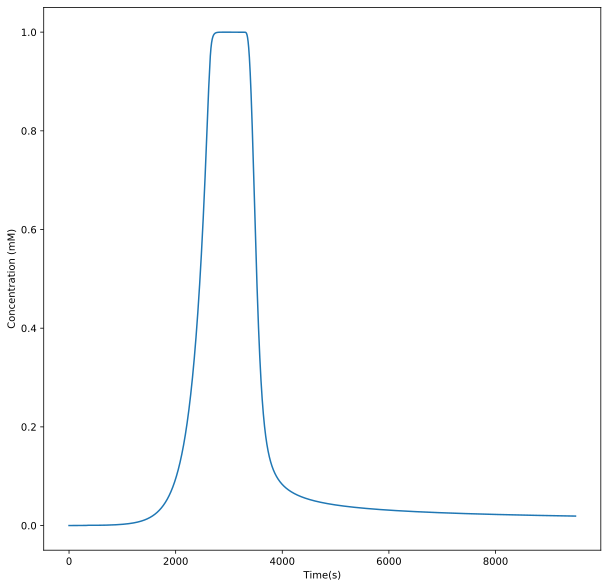

In [2]:
example_dir_1 = lesson_6 / "example_1"
example_dir_1.mkdir(exist_ok = True)

example1 = Cadet()

#give a filename for where the simulation should be saved
example1.filename = (lesson_5 / "example_2" / 'example.h5').as_posix()

example1.load()

example1.filename = (example_dir_1 / 'example.h5').as_posix()

#save the simulation
example1.save()

#run the simulation
data = example1.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example1.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example1.root.output.solution.solution_times,
                        example1.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_1 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create the matching configuration

In [3]:
match1 = Dict()
match1.CADETPath = cadet_path.as_posix()
match1.baseDir = example_dir_1.as_posix()
match1.resultsDir = 'fit_nsga3'
match1.searchMethod = 'NSGA3'
match1.gradVector = True
match1.finalGradRefinement = True
match1.population = 12

#variable transforms
parameter1 = Dict()
parameter1.transform = 'norm_keq'
parameter1.component = 0
parameter1.bound = 0
parameter1.location = ["/input/model/unit_001/adsorption/MCL_KA", "/input/model/unit_001/adsorption/MCL_KD"]
parameter1.minKA = 1e-5
parameter1.maxKA = 1e5
parameter1.minKEQ = 1e-4
parameter1.maxKEQ = 1e4

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = 0
parameter2.bound = 0
parameter2.location = "/input/model/unit_001/adsorption/MCL_QMAX"
parameter2.min = 1
parameter2.max = 20

match1.parameters = [parameter1, parameter2, ]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'Shape'

experiment1.features = [feature1,]

match1.experiments = [experiment1,]

## Run the matching process

**Don't run this right now**

The version saved in the notebook we can look through for now. It took about 10 minutes to run for me and I encourage you to run it later. You can also change the population size and other settings to see what the impact is.

The advantage of this approach is that its automatic. 

Your results are located at C:/Users/kosh_000/CADET/lessons/lesson_6/example_1/fit_nsga3 


[2019-10-16 14:33:50,117] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-16 14:33:50,117] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-16 14:33:50,117] launcher  INFO    Worker distribution: 

[2019-10-16 14:33:50,117] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-16 14:33:52,786] util      (b'127.0.0.1:51900') INFO    example.h5 abstol=0.0001  reltol=0.0001

[2019-10-16 14:33:53,422] match     (b'127.0.0.1:51900') INFO    simulation took 0.6359977722167969

[2019-10-16 14:33:54,582] gradFD    (b'127.0.0.1:51900') INFO    grad simulation took 1.128072738647461

[2019-10-16 14:33:54,582] gradFD    (b'127.0.0.1:51900') INFO    grad C:/Users/kosh_000/CADET/lessons/lesson_6/example_1/fit_nsga3/misc/template_main_grad.h5 abstol=1e-08  reltol=1e-08

[

[2019-10-16 14:38:35,173] util      (b'127.0.0.1:51900') INFO    Generation: 35 	Population: 36 	Average Score: 0.977 	Best: 0.999 	Minimum Score: 0.912 	Best: 0.996 	Product Score: 0.973 	Best: 0.999

[2019-10-16 14:38:43,057] util      (b'127.0.0.1:51900') INFO    Generation: 36 	Population: 36 	Average Score: 0.977 	Best: 0.999 	Minimum Score: 0.913 	Best: 0.996 	Product Score: 0.974 	Best: 0.999

[2019-10-16 14:38:51,010] util      (b'127.0.0.1:51900') INFO    Generation: 37 	Population: 36 	Average Score: 0.977 	Best: 0.999 	Minimum Score: 0.912 	Best: 0.996 	Product Score: 0.973 	Best: 0.999

[2019-10-16 14:38:57,970] util      (b'127.0.0.1:51900') INFO    Generation: 38 	Population: 36 	Average Score: 0.977 	Best: 0.999 	Minimum Score: 0.913 	Best: 0.996 	Product Score: 0.973 	Best: 0.999

[2019-10-16 14:39:05,493] util      (b'127.0.0.1:51900') INFO    Generation: 39 	Population: 36 	Average Score: 0.977 	Best: 0.999 	Minimum Score: 0.915 	Best: 0.996 	Product Score: 0.974 	Bes

,Time,Name,Method,Condition Number,MCL_KA Comp:0 Bound:0,MCL_KD Comp:0 Bound:0,MCL_KA/MCL_KD Comp:0 Bound:0,MCL_QMAX Comp:0 Bound:0,main_Pulse_Similarity,main_Pulse_Value,main_Pulse_Time,main_Pulse_Derivative_Similarity,main_Pulse_Der_High_Value,main_Pulse_Der_Low_Value,Product Root Score,Min Score,Mean Score,SSE
1,Wed Oct 16 14:40:22 2019,ac584dd27cff9f1b4fb2d9d6e44a1640,EVO,NaN,1.006002,0.001807,556.776447,4.874077,0.999998,1.0,0.999083,0.999971,0.999695,0.99962,0.999728,0.999083,0.999728,0.010144


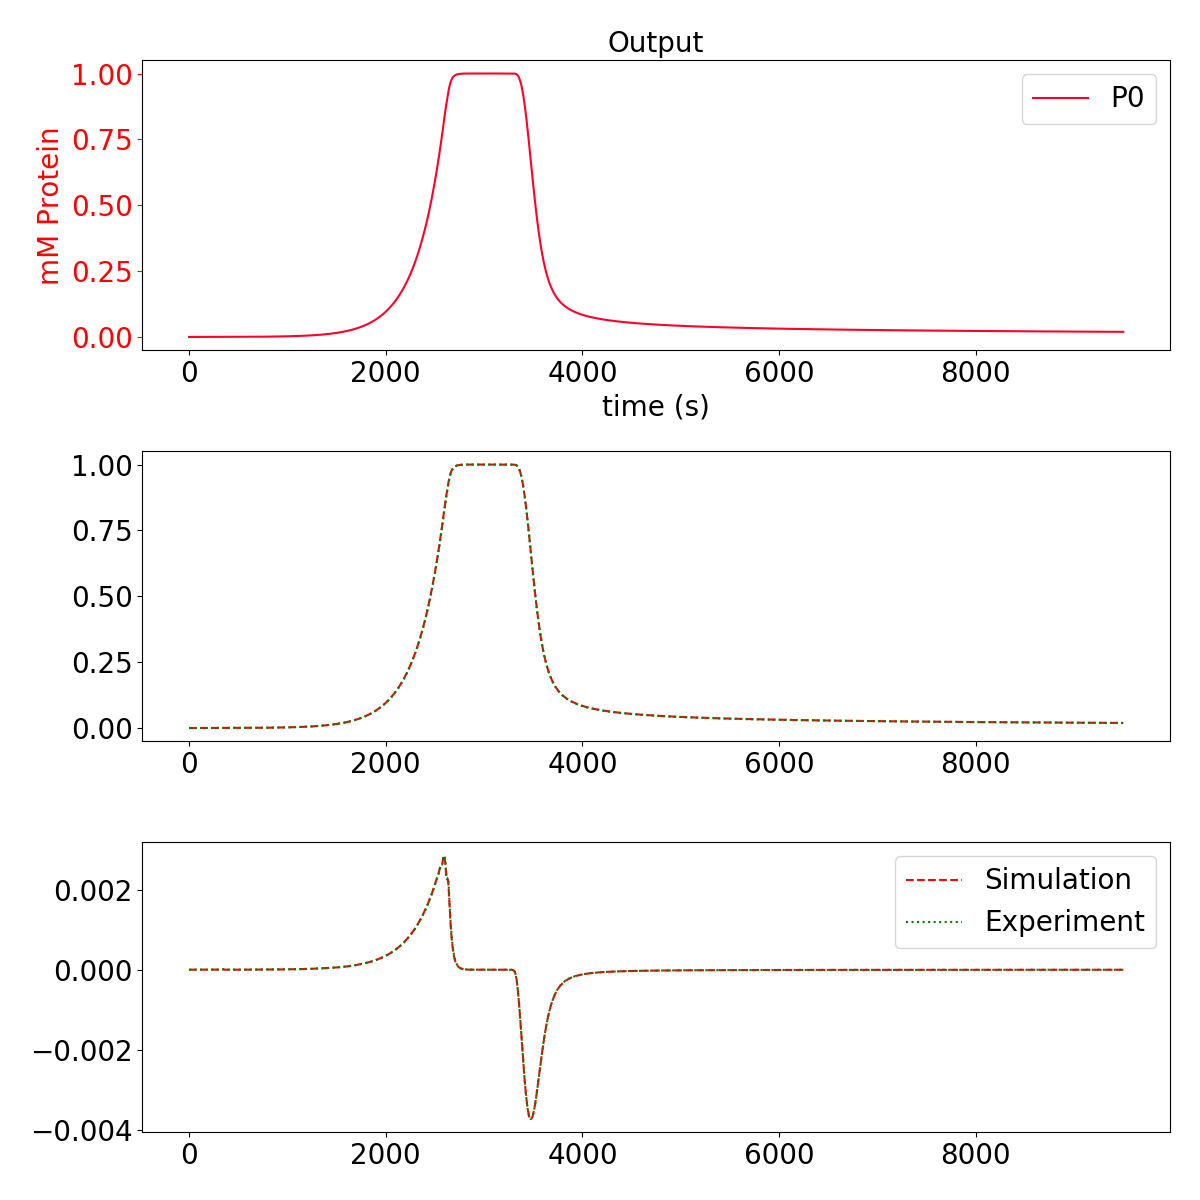

Method: Product Root Score
MCL_KA Comp:0 Bound:0 = 1.01e+00  true_value = 1.14e+00 error: 14%
MCL_KD Comp:0 Bound:0 = 1.81e-03  true_value = 2.00e-03 error: 11%
MCL_KA/MCL_KD Comp:0 Bound:0 = 5.57e+02  true_value = 5.72e+02 error: 2.7%
MCL_QMAX Comp:0 Bound:0 = 4.87e+00  true_value = 4.88e+00 error: 0.12%


Method: Min Score
MCL_KA Comp:0 Bound:0 = 1.01e+00  true_value = 1.14e+00 error: 14%
MCL_KD Comp:0 Bound:0 = 1.81e-03  true_value = 2.00e-03 error: 11%
MCL_KA/MCL_KD Comp:0 Bound:0 = 5.57e+02  true_value = 5.72e+02 error: 2.7%
MCL_QMAX Comp:0 Bound:0 = 4.87e+00  true_value = 4.88e+00 error: 0.12%


Method: Mean Score
MCL_KA Comp:0 Bound:0 = 1.01e+00  true_value = 1.14e+00 error: 14%
MCL_KD Comp:0 Bound:0 = 1.81e-03  true_value = 2.00e-03 error: 11%
MCL_KA/MCL_KD Comp:0 Bound:0 = 5.57e+02  true_value = 5.72e+02 error: 2.7%
MCL_QMAX Comp:0 Bound:0 = 4.87e+00  true_value = 4.88e+00 error: 0.12%


Method: SSE
MCL_KA Comp:0 Bound:0 = 1.01e+00  true_value = 1.14e+00 error: 14%
MCL_KD Comp

In [4]:
match_file = example_dir_1 / 'example_nsga3.json'

with (match_file).open('w') as json_file:
    json.dump(match1.to_dict(), json_file, indent='\t')

true_values = numpy.array([example1.root.input.model.unit_001.adsorption.mcl_ka,
                        example1.root.input.model.unit_001.adsorption.mcl_kd,
                        example1.root.input.model.unit_001.adsorption.mcl_ka/example1.root.input.model.unit_001.adsorption.mcl_kd,
                        example1.root.input.model.unit_001.adsorption.mcl_qmax])
    
sim_sse_large = run_match(match1,
                    match_file,
                    true_values,
                    delete=True)